In [21]:
%run "000_shared_lib.ipynb"
import cv2
import PIL as pil

# Introduction

[OpenCV Tutorials](https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_imgproc/py_histograms/py_table_of_contents_histograms/py_table_of_contents_histograms.html#table-of-content-histograms)


## Histograms

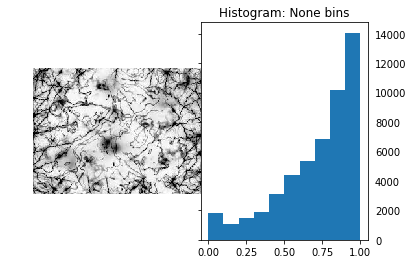

In [2]:
fname = "media/veins2.jpeg"
img = cv2.imread(fname, 0) ## 0 for gray
show_image(img)

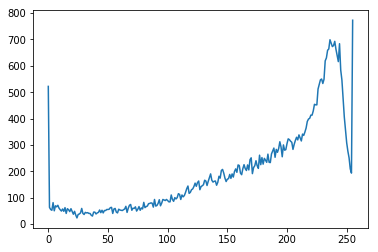

In [3]:
## Histogram 
# hist is a 256x1 array
# compare to numpy 
# hist, bins = np.histogram(img.flatten(), bins=256, ranges=[0,256])
hist = cv2.calcHist(images=[img], channels=[0], 
                    mask=None, histSize=[256], 
                    ranges=[0,256])

## The OpenCV way of plotting the hist
plt.plot(hist); 

## Histogram Equalization
To improve contrast by stretching over full spectrum

Works well for a narrow range of intensities; doesn't do well when intensity variations cover a large region such that both dark and bright pixels are present. 

**CLAHE**
Contrast Limited Adaptive Histogram Equalization.  

The default histogram equalization is a global operation. CLAHE does at hood-level (referred to as tiles, defaulat 8x8 on cv2). 

- **adaptive histogram equalization**
    - It handles situations where the intensity range is wide. It may, however, amplify noise in those hoods. 
- **Contrast limiting**
    - In order to avoid amplifying noise. 
    - a contrast limit is specified (default is 40 on cv2) and any histogram bin above that limit is clipped and distributed uniformly to other bins before equalization happens. 
    - After equalizaiton, bilinear interpolation to clean up tile borders (remove artifacts)
    


In [4]:

def subplotit(imgg, cdff, b, r):
    plt.subplot(1,2,1)
    plt.imshow(imgg, cmap='gray')
    plt.axis('off')

    plt.subplot(1,2,2)
    plt.plot(cdff, color='b')

    plt.hist(imgg.flatten(), b, r, color='r')
    plt.xlim(r)

    plt.legend(('cdf', 'hist'), loc='upper left')
    plt.clf() 

def numpy_hist_eq(img, b=256, r=[0,256]):
    ## 1. histogram xter 
    hist, binz = np.histogram(img.flatten(), b, r)
    cdf = hist.cumsum()
    cdf_norm = cdf * hist.max()/cdf.max()
        
    subplotit(img, cdf_norm, b, r) 
    
    ## 2. equalization 
    # i. first setup look up table @ output equalized pixels
    cdf_mask = np.ma.masked_equal(cdf, 0)
    cdf_m = (cdf_mask - cdf_mask.min() )*255 /( cdf_mask.max() - cdf_mask.min() )
    cdf2 = np.ma.filled( cdf_m, 0).astype('uint8')
    
    img2 = cdf2[img]
    
    subplotit(img2, cdf2, b, r) 
    
    show_image_list([img, img2], titlez=['origi', 'np equalized'])
    
    plt.show()
    
    
def cv2_hist_eq(img, b=256, r=[0,256]):
    eq = cv2.equalizeHist(img)
#     res = np.hstack( (img, eq) )
#     #show_image(res)
#     plt.imshow(img, cmap='gray')
#     plt.axis('off')
    show_image_list([img, eq], titlez=['origi', 'cv2 equalized']) 
    
def cv2_clahe(img, b=256, r=[0,256]):
    clahe = cv2.createCLAHE()
    eq = clahe.apply(img)
    show_image_list([img, eq], titlez=['origi', 'clahe equalized']) 

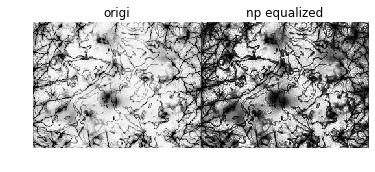

In [5]:
numpy_hist_eq(img)

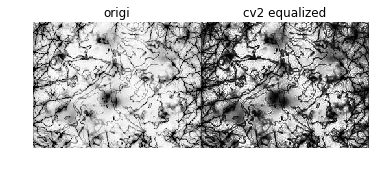

In [6]:
cv2_hist_eq(img)

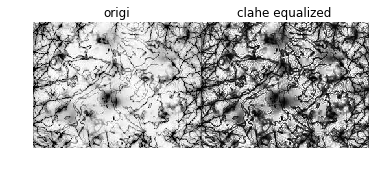

In [7]:
cv2_clahe(img)

## Histogram Backprojection
A technique for image segmentation (or finding objects of interest), where the output image contains the object of interest in more white compared to the rest of the image. 

**Process:**
- Create a histogram of an image with object of interest (OoI), call it obj_img. Color histogram is preferred. 
- 'back-project' the histogram over scene image (scene_img) on which we find the OoI
    - calculate the probability of every pixel belonging to the ground and show it.
- output upon proper thresholding gives ground alone

**TODO:**
- It is used with camshift algorithm???


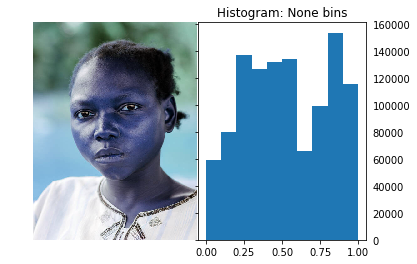

In [9]:
img2 = cv2.imread('media/img3.jpeg')
show_image(img2)

In [17]:
def cv2_color_hist(img):
    rgb = ('r', 'g', 'b')
    for i,c in enumerate(rgb):
        hist = cv2.calcHist(images=[img], channels=[i], 
                        mask=None, histSize=[256], 
                        ranges=[0,256])

        ## The OpenCV way of plotting the hist
        plt.plot(hist, color=c); 
    plt.legend([f"channel {x}" for x in rgb], loc='upper left')
    plt.title("Color histogram")
    plt.show()
    
def np_color_hist(img, b=256, r=[0,256]): 
    pass

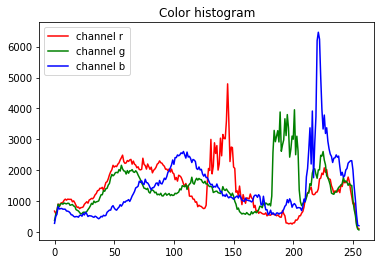

In [16]:
cv2_color_hist(img2)

In [167]:
def make_art_pixel(size, ck=0, seed=4):
    rander = np.random.RandomState(seed)
    rshift = 3
    w, h = size 
    
    outsie = np.ones((h, w, 3))*128
    for y in range(1, h):
        outsie[y, 0] = outsie[y-1, 0] + rander.randint(-rshift, rshift+1, size=3)
        
    for x in range(1, w):
        for y in range(1, h-1):
            outsie[y,x] = ((outsie[y-1, x-1] + outsie[y, x-1] + outsie[y+1, x-1])/3) + rander.randint(-rshift, rshift+1, size=3)
    
    imgout = pil.Image.fromarray(outsie.astype(np.uint8)).convert('RGB')
    
    return np.asarray( imgout )

def make_scene(img, w=2048, h=1600):
    iw, ih, _ = img.shape
    print(img.shape)
    
    outsie =  skimage.img_as_float32(make_art_pixel((w,h)).copy())
#     outsie = np.zeros((w,h,3), dtype=np.float32)
#     outsie [:,:,0] = 220   
#     outsie [:,:400,1] = 220   
#     outsie [:1400,:,2] = 220 
#     outsie [400:1800,200:400,0] = 20     
    sx = np.random.randint(0, iw, 1)[0]
    sy = np.random.randint(0, ih, 1)[0]
    
    ex = min(w, sx+iw)
    ey = min(w, sy+ih)
    outsie[ sx:ex, sy:ey, :] = skimage.img_as_float32(img)[:(ex - sx), :(ey - sy), :]
    #outsie = outsie.paste(pil.Image.fromarray(img), (sx, sy) )#, ex, ey))    
    #outsie = np.asarray(outsie)
    
    print( outsie.shape )
    
    show_image_list([img, outsie], titlez=['object', 'scene'])
    
    return outsie 

(700, 525, 3)
(1600, 2048, 3)


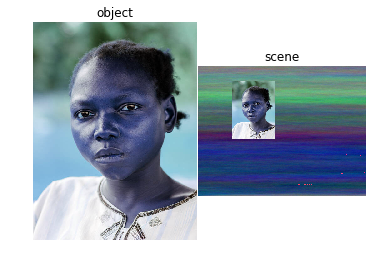

In [168]:
target_scene = make_scene(img2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


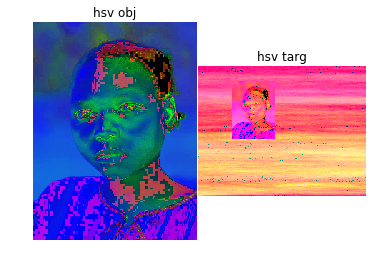

In [169]:
# roi = region of interest = img2
# make hsv b/c 
roi_hsv = cv2.cvtColor(img2, cv2.COLOR_BGR2HSV)
target_hsv = cv2.cvtColor(target_scene, cv2.COLOR_BGR2HSV)

show_image_list([roi_hsv, target_hsv], titlez=['hsv obj', 'hsv targ'])

## histograms
hist_roi = cv2.calcHist([roi_hsv], [0,1], None, [180, 256], [0,180, 0, 256])
hist_target = cv2.calcHist([target_hsv], [0,1], None, [180, 256], [0,180, 0, 256])


In [170]:
# find the ratio R = M/I, the backproject R i.e. use R as  palette and create new i mage with eery pizel as its corresponding probabiliyt of being target
R = hist_roi/hist_target
print( R.shape )
h, s, v = cv2.split(target_hsv)
print(h.shape)
B =  R[h.ravel(), s.ravel()] ##
B = np.minimum(B, 1)
B = B.reshape(target_hsv.shape[:2])

(180, 256)
(1600, 2048)


/home/moranis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in true_divide
  
/home/moranis/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


IndexError: arrays used as indices must be of integer (or boolean) type

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


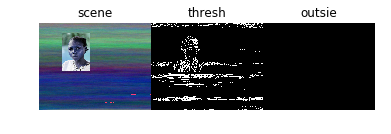

In [171]:
## OpenCV backproject

# normalize histogram and apply backprojection
cv2.normalize(hist_roi, hist_roi, 0, 255, cv2.NORM_MINMAX)
dst = cv2.calcBackProject([target_hsv], [0,1], hist_roi, [0,180,0,256],1)

## convolve with circular disc
disc = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5,5))
cv2.filter2D(dst, -1, disc, dst)

## threshold and binary &&
ret, thresh = cv2.threshold(dst, 50, 255, 0)
thresh = cv2.merge((thresh, thresh, thresh))
res = cv2.bitwise_and( target_scene, thresh)
# res = cv2.colorChange(res, cv2.COLOR_GRAY2BGR)

show_image_list([target_scene, thresh, res],
               titlez=['scene', 'thresh', 'outsie'], nc=3);

<class 'numpy.ndarray'>


(100, 200, 3)

(-0.5, 199.5, 99.5, -0.5)

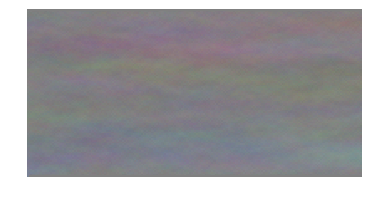

In [172]:
a = make_art_pixel((200,100))
print( type(a))
a.shape
plt.imshow(a)
plt.axis('off')

# Color Space

In [175]:
## BGR -- Gray , BGR--HSV
# cv2.cvtColor for color conversion.
# cv2.cvtRange for 
color_flags = [c for c in dir(cv2) if c.startswith('COLOR_')]
print("# of color flags: ", len(color_flags))

#### HSV @ cv2 
## hue range:       [0, 179]
## saturation:      [0,255]
## value range:     [0, 255]
#####


# of color flags:  274


### 1. Object Tracking 

Convert to HSV space, then extract colored object. b/c easier to represent a color than in RGB space. 
- convert image to HSV space
- threshold hsv image for a range of say blur color to extract blue object 
- extract the object by itself

Img3:  (583, 800, 3) <class 'numpy.ndarray'>


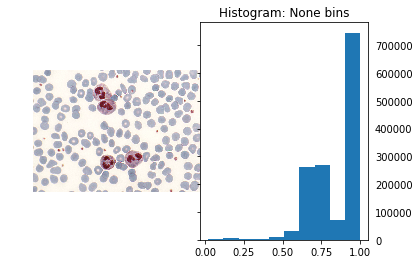

In [183]:
def get_image(fpath):
    img = cv2.imread(fpath)
    print("Img3: ", img.shape, type(img))
    show_image(img)    
    return img

img_bloodcells = get_image('media/cells2.jpg') 


In [215]:
def extract_color_object(img, colr_lo=[0,100,90], colr_hi=[250,250,200]):
    # hsv convert 
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV) 
    #threshold 
    colr_lo = np.array( colr_lo)
    colr_hi = np.array( colr_hi)
    mask = cv2.inRange(hsv, colr_lo, colr_hi)
    # bitwise and mask + orig
    outsie = cv2.bitwise_and(img, img, mask=mask)
    
    show_image_list([img, mask, outsie],
                   titlez=['origi', 'mask', 'filtered'], nc=3)
    

In [220]:
## get hsv color we want to track 
c =  np.uint8([[[255,0,0],[0,0,255]]]) ## rgb red and blue 
ch = cv2.cvtColor(c, cv2.COLOR_RGB2HSV)
print( ch )

[[[  0 255 255]
  [120 255 255]]]


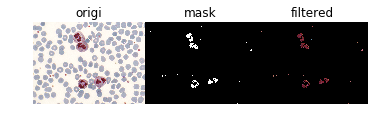

In [216]:
extract_color_object(img_bloodcells)

## Geometric Transforms

Img3:  (183, 275, 3) <class 'numpy.ndarray'>


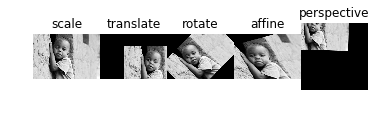

In [243]:
img = get_image("media/img2.jpeg")
nr, nc, cc = img.shape
M_trans = np.float32([
    [1,0,100],
    [0,1,50]
])

## cv2 can also do scaled rotation via cv2.getRotationMatrix2D
theta = 45
M_rotate = np.float32([
    [ np.cos(theta), -np.sin(theta)],
    [ np.sin(theta), np.cos(theta)]
])
scaled_rotate = cv2.getRotationMatrix2D((nc/2, nr/2), theta, 1)

## Affine transformation - all parallel lines remain parallel after transformation. takes in 2x3 points of
pts1 = np.float32([[50,50],[200,50],[50,200]])
pts2 = np.float32([[10,100],[200,50],[100,250]])
affine = cv2.getAffineTransform(pts1, pts2)


## Perspective transformation - straight line remain straight after transformation. takes in 3x3. 
# 4 points on input image and corresponding points on output image minimum rank is 3; 3 should not be colinear
pts1 = np.float32([[56,65],[368,52],[28,387],[389,390]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])
perspective = cv2.getPerspectiveTransform(pts1, pts2)




fxnz = [(cv2.resize, {'dsize':None,'fx':2, 'fy':2, 'interpolation':cv2.INTER_CUBIC}),
       (cv2.warpAffine, {'M':M_trans, 'dsize':(nc,nr)}),
      (cv2.warpAffine, {'M':scaled_rotate, 'dsize':(nc, nr)}),
      (cv2.warpAffine, {'M':affine, 'dsize':(nc, nr)} ) ,
      (cv2.warpPerspective, {'M':perspective, 'dsize':(300,300)} ) 
       ]
fxnamez = ['scale', 'translate', 'rotate', 'affine', 'perspective']


output = []
titlez = []
for fx, fname in zip(fxnz, fxnamez):
    try:
        output.append( fx[0](img, **fx[1]) )
        titlez.append( fname )
    except:
        pass
    
show_image_list(output, titlez=titlez, nc=len(titlez))

# Image Thresholding

Converts images into binary images 
Operates on grayscale 

**Styles**
- BInary
- Binary_Inv
- Trunc
- ToZero
- ToZero_Inv:


**Methods**
- Simple thresholding: against whatever constant is given, global level
- Adaptive thresholding: hood-level, 
    - Mean: mean of hood as threshold 
    - Gaussian: weighted sum of hood using gaussian window as weights
- OTSU thresholding:  

In [246]:
thr_namez = [x for x in dir(cv2) if x.startswith('THRESH_')]
print(thr_namez)

thr_namez = ['THRESH_BINARY', 'THRESH_BINARY_INV', 'THRESH_TRUNC']

['THRESH_BINARY', 'THRESH_BINARY_INV', 'THRESH_MASK', 'THRESH_OTSU', 'THRESH_TOZERO', 'THRESH_TOZERO_INV', 'THRESH_TRIANGLE', 'THRESH_TRUNC']


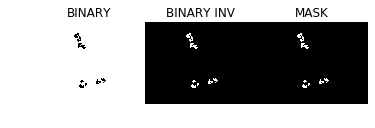

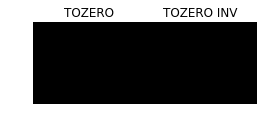

<Figure size 432x288 with 0 Axes>

In [258]:

def simple_threshold(img, thresh=70):
    th_fxnz = [cv2.THRESH_BINARY, cv2.THRESH_BINARY_INV,  
               cv2.THRESH_TOZERO, cv2.THRESH_TOZERO_INV, 
               cv2.THRESH_TRUNC]
    
    n = len(th_fxnz)
    nc = 3 
    nr = n//nc
    nr += 0 if (n%nc == 0) else 1
    
    for i in range(nr):
        outsiez = []
        titlez = []
        for j in range(nc):
            x = j + (nc * i)
            if x >= len(th_fxnz):
                break
            r, img = cv2.threshold(img, thresh, 255, th_fxnz[x])
            outsiez.append(img)
            titlez.append( " ".join(thr_namez[ x ].split('_')[1:]) ) 
        show_image_list(outsiez, titlez=titlez, nc=nc)
        plt.clf()
    plt.show();
    
simple_threshold( cv2.cvtColor(img_bloodcells, cv2.COLOR_BGR2GRAY) )

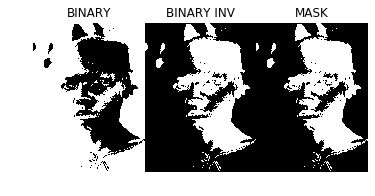

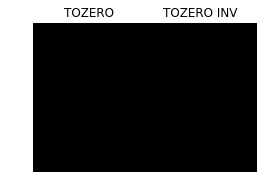

<Figure size 432x288 with 0 Axes>

In [262]:
simple_threshold( cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY), thresh=90 )

In [271]:
def adaptive_thresholding(img, simple_thresh=cv2.THRESH_BINARY):
    # for comparison sake 
    _, binary = cv2.threshold( img, 127, 255, simple_thresh)
    
    # adaptives. Can use simple thresholding at hood level 
    mean_c = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  simple_thresh, 11, 2)
    gauss_c = cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                  simple_thresh, 11, 2)
    
    show_image_list([img, binary, mean_c, gauss_c],
                   titlez=['origi', 'binary', 'adpt-mean', 'adpt-gaus'])

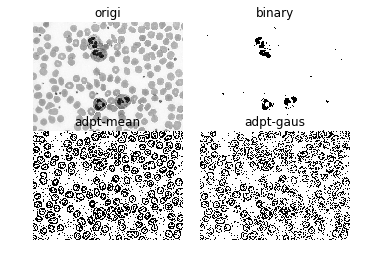

In [272]:
adaptive_thresholding(cv2.cvtColor(img_bloodcells, cv2.COLOR_BGR2GRAY) )adaptive_thresholding(cv2.cvtColor(img_bloodcells, cv2.COLOR_BGR2GRAY) )

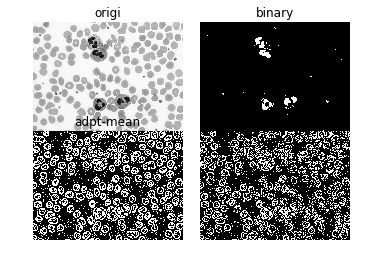

In [274]:
adaptive_thresholding(cv2.cvtColor(img_bloodcells, cv2.COLOR_BGR2GRAY), simple_thresh=cv2.THRESH_BINARY_INV )

## OTSU
Global thresholding uses some arbitrary value to threshold and so by trial and error, we find a suitable threshold.

OTSU binarization seeks a 'separator' e.g. if bimodal image then where the distribution 'transitions' and uses that as the threshold - autocalculates threshold form image histogram for a bimodal image.

For non-bimodal images, OTSU is not as accurate.



In [268]:
def otsu_thresholding(img, simple_thresh=cv2.THRESH_BINARY):
    # for comparison sake 
    _, binary = cv2.threshold( img, 127, 244, simple_thresh)
    
    # otsu 
    _, otsu = cv2.threshold(img, 0, 255, cv2.THRESH_OTSU+simple_thresh)
    
    # otsu with smoothing 
    gauss = cv2.GaussianBlur(img, (5,5), 0)
    _, gauss_otsu = cv2.threshold(gauss, 0, 255, cv2.THRESH_OTSU+simple_thresh)
    
    show_image_list([img, binary, otsu, gauss_otsu],
                   titlez=['origi', 'binary', 'otsu', 'otsu-gaus'])

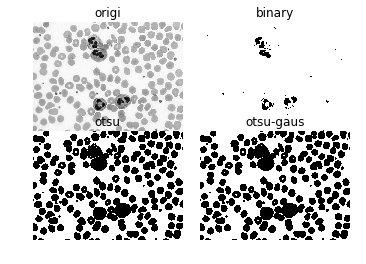

In [275]:
otsu_thresholding(cv2.cvtColor(img_bloodcells, cv2.COLOR_BGR2GRAY))

# Blurring and Sharpening

**Bilateral Filtering** Does noise removal (blurring/smoothing) while preserving edges

E.g. Gaussian is based on spacial information only. It doesn't take into account the intensity value or if a pixel is an edge or not. And so gaussian tends to blur edges, which is undesirable

**Bilateral Filter Process**
- Guassian filter in the space domain - this ensures only hood-level changes 
- Multiplicative gaussian filter that is a function of pizel intensity differences - this intesity domain operation ensures only intensity similar pixels (relative to central pixel) considered in the blurred value 
- 


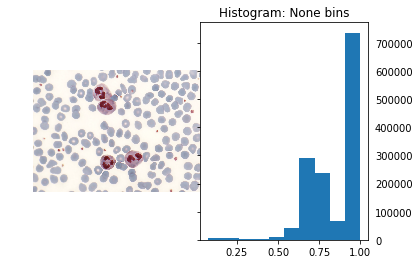

In [276]:
## Bilateral Filtering
# 
blur = cv2.bilateralFilter(img_bloodcells, 9, 75, 75)
show_image(blur)

# Image Pyramids
A set of different resolution images from same image

1. Gaussian Pyramid
- Lower Resolution images (higher level) are formed by 
    - removing consecutive rows and columns from the higher resolution (lower level) image. 
    - And then each pixel is formed by the contribution ofrom 5 pixels in the underlying level with gaussian weights. 
    - And so an $M x N$ image becomes $M/2 x N/2$ and so the area reduces by $1/4$
    - An octave
    - Repeat at next lower resolution. And the opposite when going from lower to higer resolution. 
    - `cv2.pyrDown` and `cv2.pyrUp` 

2. Laplacian Pyramids 
- Are formed from the gaussian. 
    - A level is formed by the difference between that elvel in gaussian pyramid and expanded version of its upper level in gaussian pyramid 
- laplacian pyramid images are lke edge images only. Most of the elements are zeros.
- Used in image compression. 


**Applications**
- Image Blending
    - i.e. stiching images together. 

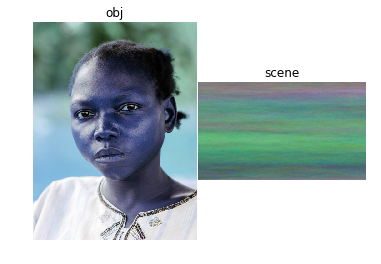

In [279]:
scene = make_art_pixel((1024, 600))
show_image_list([img2, scene], titlez=['obj', 'scene'])

In [309]:
pyramid_n = 6
## Gaussian pyramid
def gen_gauss_pyramid_down(img, pyramid_n=pyramid_n):
    g = img.copy()
    gpa = [g]
    for i in range(pyramid_n):
        g = cv2.pyrDown(g)
        gpa.append( g )
    return gpa
    
def gen_laplacian_pyramids_down(gpa, pyramid_n=pyramid_n):
    lpa = [ gpa[pyramid_n-1] ]
    for i in range(pyramid_n-1, 0, -1):
        ge = cv2.pyrUp( gpa[i] ) 
        print("type ge: ", type(ge))
        print("type gpa: ", type(gpa[i-1]))
        l = cv2.subtract( gpa[i-1], ge)
        lpa.append(l)
    return lpa

def add_two_halves(lpa, lpb):
    outsie = []
    for la, lb in zip(lpa, lpb):
        rows, cols, dpt = la.shape
        ls = np.hstak( (la[:,:cols//2], lb[:, cols//2:]) )
        outsie.append( ls )
        
    return outsie

def reconstruct_blended(ls, n=pyramid_n):
    ls_ = ls[0]
    for i in range(1, n):
        ls_ = cv2.pyrUp( ls_)
        ls_ = cv2.add(ls_, ls[i])
    return ls_

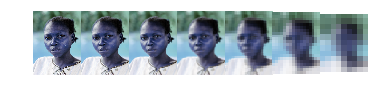

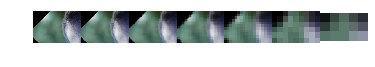

In [310]:
obj_img1 = skimage.img_as_float32(img2)
# obj_img2 = cv2.rotate(obj_img1, 90)
obj_img2 = cv2.warpAffine( obj_img1, **{'M':scaled_rotate, 'dsize':(nc, nr)})
    
    
obj_gpa = gen_gauss_pyramid_down( obj_img1)
scene_gpa = gen_gauss_pyramid_down( obj_img2 )

show_image_list(obj_gpa, nc=pyramid_n+1)
plt.clf();

show_image_list(scene_gpa, nc=pyramid_n+1)
plt.show();

In [311]:
obj_lpa = gen_laplacian_pyramids_down( obj_gpa)
scene_lpa = gen_laplacian_pyramids_down( scene_gpa )

show_image_list(obj_lpa, nc=pyramid_n)
plt.clf();

show_image_list(scene_lpa, nc=pyramid_n)
plt.show();

type ge:  <class 'numpy.ndarray'>
type gpa:  <class 'numpy.ndarray'>


error: OpenCV(3.4.2) /tmp/build/80754af9/opencv-suite_1535558553474/work/modules/core/src/arithm.cpp:656: error: (-209:Sizes of input arguments do not match) The operation is neither 'array op array' (where arrays have the same size and the same number of channels), nor 'array op scalar', nor 'scalar op array' in function 'arithm_op'


In [ ]:
outsie = reconstruct_blended( add_two_halves(obj_lpa, scene_lpa) ) 

plt.imshow(outsie)